In [45]:
import pandas as pd
import sqlite3
import pandas_profiling
import seaborn as sns

In [46]:
path_search = 'MyData/SearchQueries.json'
df_search = pd.read_json(path_search)

# Cleaning the Data
df_search['searchTime'] = df_search['searchTime'].str[:-5]
df_search['searchTime'] = pd.to_datetime(df_search['searchTime'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
df_search['platform'] = df_search['platform'].astype('str')
df_search['searchQuery'] = df_search['searchQuery'].astype('str')
df_search['searchInteractionURIs'] = df_search['searchInteractionURIs'].astype('str')

df_search.head()

,platform,searchTime,searchQuery,searchInteractionURIs
0,ANDROID,2020-02-07 12:49:26.512000+00:00,Moonlight,['spotify:track:6L4F4btXioJPhEwz6T7YYt']
1,ANDROID,2020-02-08 21:44:06.888000+00:00,mc guime,['spotify:artist:3ge4xOaKvWfhRwgx0Rldov']
2,ANDROID,2020-02-09 20:52:42.231000+00:00,My Only One (No Hay Nadie Más) Sebastián Yatra,[]
3,ANDROID,2020-02-13 01:15:16.958000+00:00,idont,['spotify:track:41zXlQxzTi6cGAjpOXyLYH']
4,ANDROID,2020-02-15 13:52:02.476000+00:00,ted talk,['spotify:show:1VXcH8QHkjRcTCEd88U3ti']


Como temos três arquivos de Streaming, vou concatenar todos em um DF só.

In [47]:
paths_streaming = ['MyData/StreamingHistory0.json', 'MyData/StreamingHistory1.json', 'MyData/StreamingHistory2.json']

df_streaming = pd.DataFrame([])

for path in paths_streaming:
    df_temp = pd.read_json(path)
    df_streaming = pd.concat([df_streaming, df_temp])

df_streaming.head()

,endTime,artistName,trackName,msPlayed
0,2019-04-28 14:19,MC L da Vinte,Parado no Bailão,25390
1,2019-04-30 14:25,MC Kevin o Chris,Dentro do Carro,50800
2,2019-05-01 09:54,Mc Livinho,Espelho No Teto,192947
3,2019-05-01 09:58,UCLÃ,Pa Pa Pa,230357
4,2019-05-01 10:03,MC L da Vinte,Parado no Bailão,5630


Salvando em um SQLite, para ficar mais fácil de ler as informações:

In [48]:
connection = sqlite3.connect('data/database_spotify.db')
cursor = connection.cursor()

In [49]:
# SEARCH
cursor.execute('DROP TABLE IF EXISTS SEARCH;')
cursor.execute('CREATE TABLE SEARCH (platform, searchTime, searchQuery, searchInteractionURIs)')
connection.commit()

df_search.to_sql('SEARCH', connection, if_exists='replace', index=False)

## testing the results
cursor.execute('''  
SELECT * FROM SEARCH LIMIT 10
          ''')

df_temp = pd.DataFrame(cursor.fetchall(), columns=['platform', 'searchTime', 'searchQuery', 'searchInteractionURIs'])    
df_temp.head()

,platform,searchTime,searchQuery,searchInteractionURIs
0,ANDROID,2020-02-07 12:49:26.512000+00:00,Moonlight,['spotify:track:6L4F4btXioJPhEwz6T7YYt']
1,ANDROID,2020-02-08 21:44:06.888000+00:00,mc guime,['spotify:artist:3ge4xOaKvWfhRwgx0Rldov']
2,ANDROID,2020-02-09 20:52:42.231000+00:00,My Only One (No Hay Nadie Más) Sebastián Yatra,[]
3,ANDROID,2020-02-13 01:15:16.958000+00:00,idont,['spotify:track:41zXlQxzTi6cGAjpOXyLYH']
4,ANDROID,2020-02-15 13:52:02.476000+00:00,ted talk,['spotify:show:1VXcH8QHkjRcTCEd88U3ti']


In [50]:
# STREAMING
# cursor.execute('CREATE TABLE STREAMING (endTime, artistName, trackName, msPlayed)')
# connection.commit()
# df_streaming.to_sql('STREAMING', connection, if_exists='replace', index=False)

## testing the results
cursor.execute('''  
SELECT * FROM STREAMING LIMIT 10
          ''')

df_temp = pd.DataFrame(cursor.fetchall(), columns=['platform', 'searchTime', 'searchQuery', 'searchInteractionURIs'])  

df_temp.head()

,platform,searchTime,searchQuery,searchInteractionURIs
0,2019-04-28 14:19,MC L da Vinte,Parado no Bailão,25390
1,2019-04-30 14:25,MC Kevin o Chris,Dentro do Carro,50800
2,2019-05-01 09:54,Mc Livinho,Espelho No Teto,192947
3,2019-05-01 09:58,UCLÃ,Pa Pa Pa,230357
4,2019-05-01 10:03,MC L da Vinte,Parado no Bailão,5630


# Salvando os Dados

Após limpar os dados e colocar eles disponíveis em um SQLite, segue as primeiras visualizações. Decidi usar uma biblioteca "pronta" de visualização de dados chamada `pandas_profiling`: ele vai reproduzir um relatório em HTML para validar os principais elementos.

In [51]:
profile = df_streaming.profile_report(title='Streaming Spotify Report')
profile.to_file(output_file="./report/streaming_spotify.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 183.57it/s]


In [52]:
profile = df_search.profile_report(title='Search Spotify Report')
profile.to_file(output_file="./report/search_spotify.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 366.86it/s]


# Outras Análises


In [53]:
# Knowing what if the main aristist listened.
cursor.execute('''  
    SELECT artistName AS artista, SUM(msPlayed) AS consumo
    FROM STREAMING
    GROUP BY artistName
    ORDER BY consumo DESC
    LIMIT 10
          ''')

df_temp = pd.DataFrame(cursor.fetchall(), columns=['artista', 'consumo'])    
df_temp.head()

,artista,consumo
0,Xadrez Verbal,279306783
1,NerdCast,251386979
2,Hipsters Ponto Tech,170465019
3,Panic! At The Disco,94826915
4,Post Malone,80213739


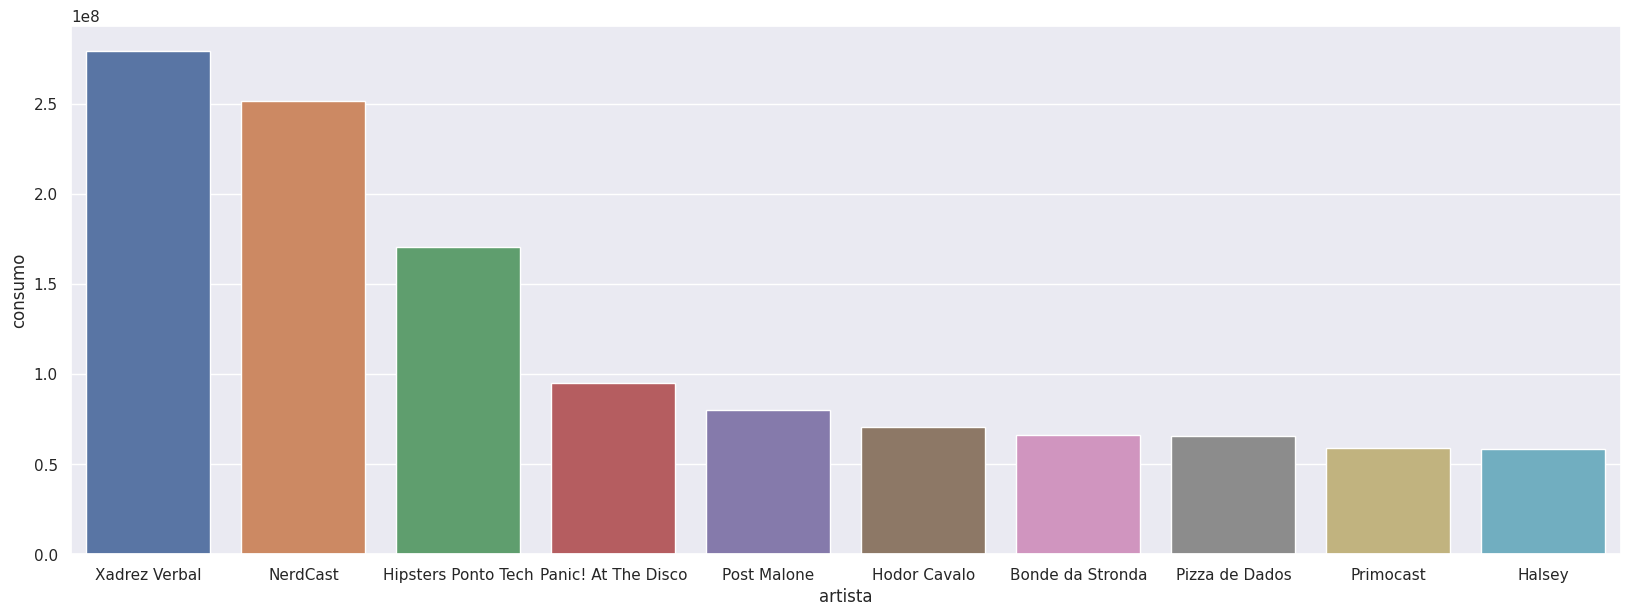

In [54]:
sns.set(rc={'figure.figsize':(20,7)})
sns.barplot(x="artista", y="consumo", data=df_temp)

In [55]:
# Knowing what if the main aristist listened.
cursor.execute('''  
    SELECT strftime('%Y-%m', endTime) AS periodo, SUM(msPlayed) AS consumo
    FROM STREAMING
    GROUP BY periodo
    ORDER BY periodo
          ''')

df_temp = pd.DataFrame(cursor.fetchall(), columns=['periodo', 'consumo'])    
df_temp.head()

,periodo,consumo
0,2019-04,76190
1,2019-05,298513163
2,2019-06,345917060
3,2019-07,435243392
4,2019-08,187034556


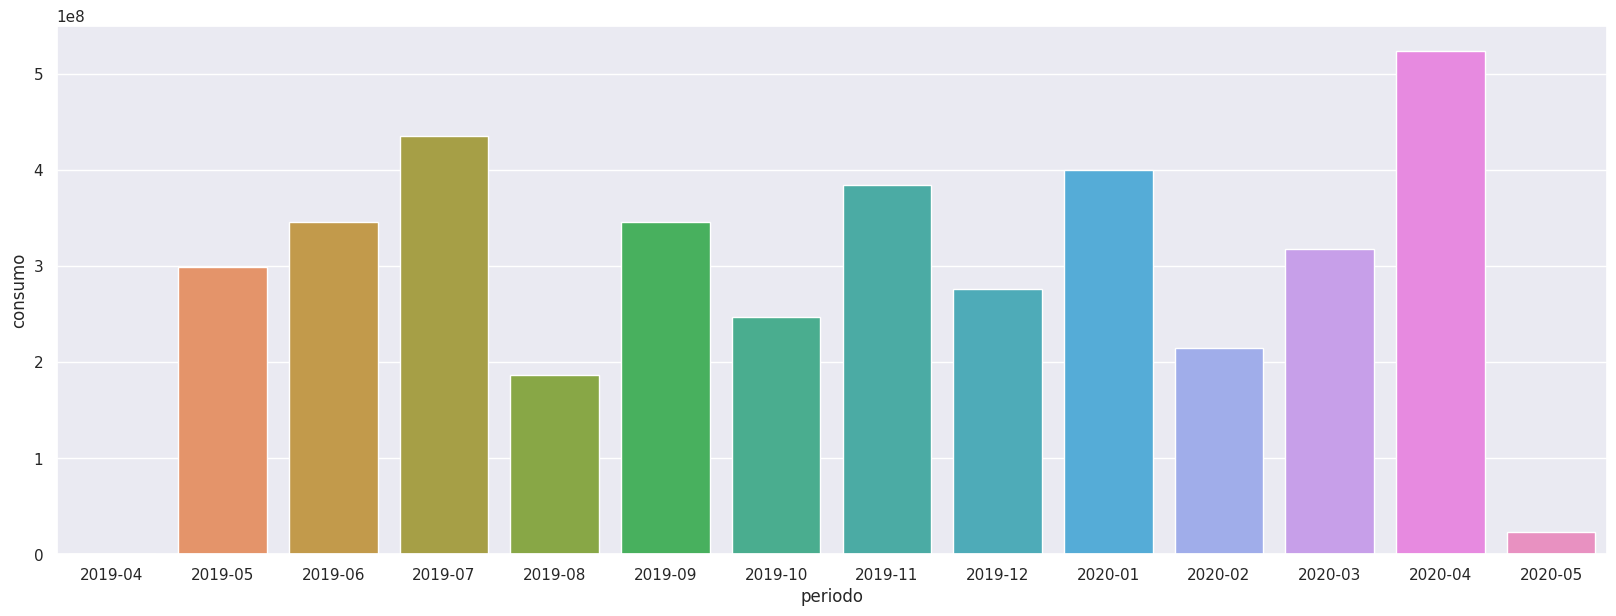

In [56]:
sns.set(rc={'figure.figsize':(20,7)})
sns.color_palette("ch:2.5,-.2,dark=.3")
sns.barplot(x="periodo", y="consumo", data=df_temp)